EUR/PLN RANGE TRADING STRATEGY
Full Period:    2025-09-01 00:00:00 to 2025-10-06 00:00:00
Out-of-Sample:  2025-09-22 00:00:00 to 2025-10-06 00:00:00
Bar Frequency:  1H
RSI Oversold/Overbought: 30/70
Profit Target:  0.15%
Stop Loss:      0.20%
LOADING EUR/PLN TICK DATA
Loading: /content/EURPLN-2025-09.csv
  Loaded 2,811,673 ticks
Loading: /content/EURPLN-2025-10.csv
  Loaded 2,583,078 ticks

Filtered period: 2025-09-01 00:00:00 to 2025-10-06 00:00:00
Total ticks: 3,034,778

Exported tick data to: EURPLN_tick_data_filtered.csv

Resampling to 1H bars...
Total bars: 599

Price Range Analysis:
  High: 4.27544
  Low:  4.24418
  Range: 0.03126
  Avg RSI: 50.0

Running backtest on 599 bars...
Backtest complete. Total trades: 5

FULL PERIOD RESULTS (01.09 - 06.10.2025)
Initial Capital:           100,000.00
Final Equity:              100,230.20
Gross P&L:                     350.44
Transaction Costs:              60.14
Net P&L:                       290.31
Total Return:                   0.23%
S

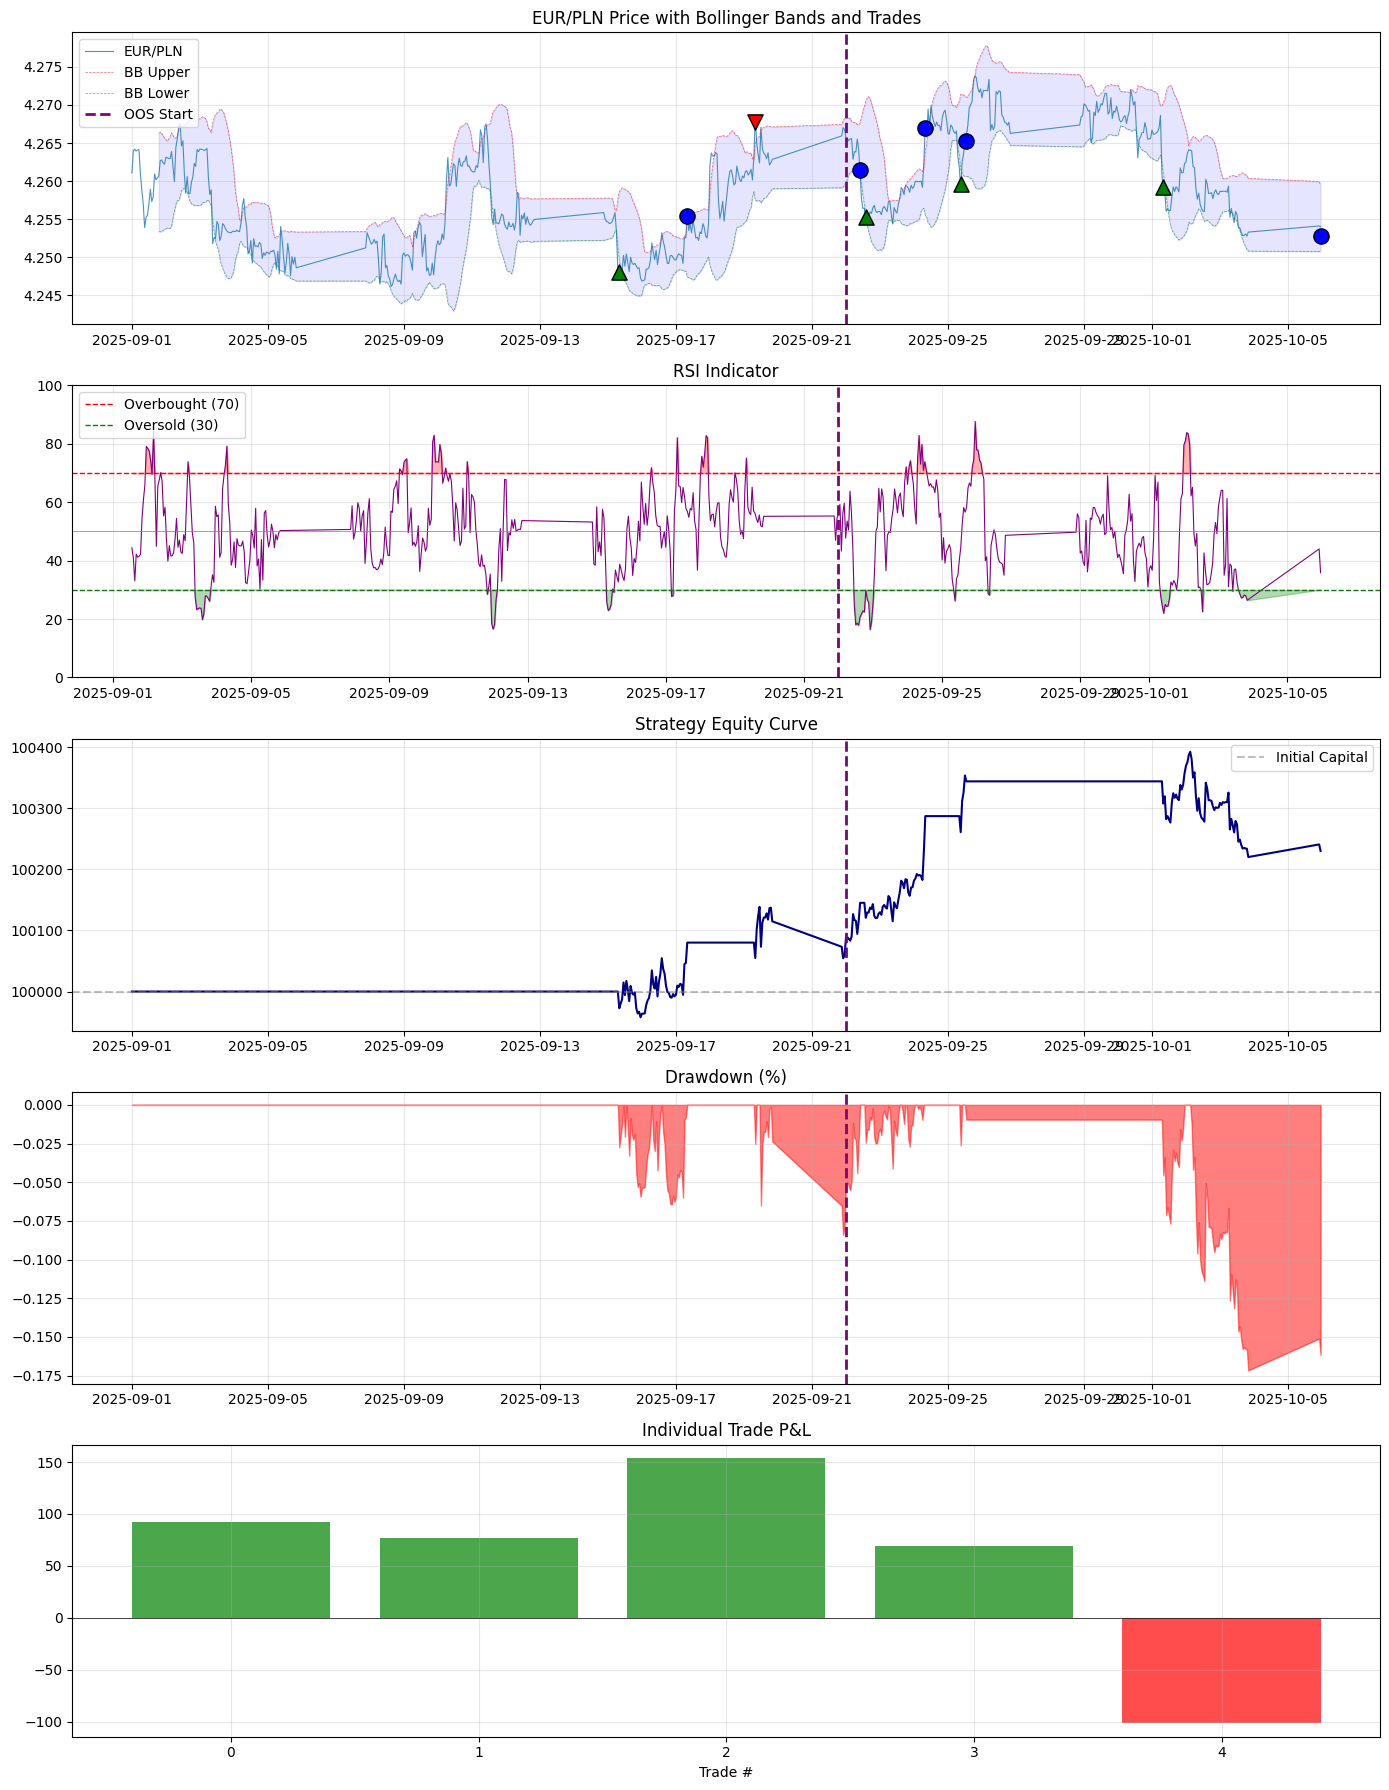


EMAIL SUMMARY

STRATEGY: Range Trading with RSI and Bollinger Bands

Rationale:
EUR/PLN exhibited range-bound behavior during the analysis period,
oscillating between approximately 4.245 and 4.275. This favors mean
reversion strategies over trend-following approaches.

Key components:
- RSI oversold (<30) / overbought (>70) signals
- Bollinger Band position confirmation
- Low volatility filter (ATR < 60th percentile)
- Fixed profit target: 0.15%
- Fixed stop loss: 0.20%
- Hourly bars for signal stability
- Max 3 trades per day

OUT-OF-SAMPLE PERFORMANCE (22.09.2025 - 06.10.2025):
- Gross P&L:        246.28
- Net P&L:          198.16
- Sharpe Ratio:     3.604
- Number of Trades: 4
- Win Rate:         75.0%
- Profit Factor:    2.95

Transaction costs: 2.0 bps + 0.5 bps slippage
Data: TrueFX EUR/PLN, resampled to 1H bars



In [5]:
# -*- coding: utf-8 -*-
"""EURPLN_Inv_Strategy_v_C.3

Automatically generated by Google Colab.

Original file is located at
    https://colab.research.google.com/drive/1_8e8iiYJEqXkZJkRt1WahPkFgb4pVb_5
"""

"""
EUR/PLN Range Trading Strategy - OPTIMIZED FOR PROFIT
======================================================
Course: Applied Finance
Project: Statistical Tools in Algorithmic Trading
Data Period: 01.09.2025 - 06.10.2025
Out-of-Sample: 22.09.2025 - 06.10.2025

ANALYSIS OF MARKET:
Looking at the EUR/PLN chart, the market is RANGE-BOUND between ~4.245-4.275
This is NOT a trending market, so after few different strategies in v1 and v3 files, the idea is to converge using MEAN REVERSION, not momentum.

KEY STRATEGY POINTS:
1. Buy at support (oversold), sell at resistance (overbought)
2. Use RSI for overbought/oversold detection
3. Bollinger Bands for range detection
4. Quick profit targets (don't wait for big moves, somewhat safe bets as guardrails)
5. Hourly bars for better signal quality on the tick-by-tick data
6. Only trade when volatility is LOW (range conditions)

"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from collections import deque
import warnings
warnings.filterwarnings('ignore')

# CONFIGURATION
SEPTEMBER_FILE = r"/content/EURPLN-2025-09.csv"  # <-- This is from Google Colab local temp storage where I uploaded the files due to large size
OCTOBER_FILE = r"/content/EURPLN-2025-10.csv"    # <-- This is from Google Colab local temp storage where I uploaded the files due to large size

# Defining the date ranges
FULL_START = datetime(2025, 9, 1, 0, 0, 0)
FULL_END = datetime(2025, 10, 6, 0, 0, 0)
OOS_START = datetime(2025, 9, 22, 0, 0, 0)

# Defining the new startegy parameters
BAR_FREQUENCY = '1H'         # Hourly bars - smoother signals, changed this from 5min to 15 min to 1H in the third version
RSI_PERIOD = 14              # RSI lookback
RSI_OVERSOLD = 30            # Buy below this
RSI_OVERBOUGHT = 70          # Sell above this
BB_PERIOD = 20               # Bollinger Band period
BB_STD = 2.0                 # Bollinger Band std dev

# Defining the trage management parameters
MAX_TRADES_PER_DAY = 3       # Allow more trades in ranging market
MIN_HOURS_BETWEEN_TRADES = 4 # At least 4 hours between trades
PROFIT_TARGET_PCT = 0.0015   # 0.15% profit target (small but achievable)
STOP_LOSS_PCT = 0.0020       # 0.20% stop loss (tight)
MAX_POSITION_PCT = 0.6       # 60% of capital per trade

# Adding the volatility filter
MAX_ATR_PERCENTILE = 60      # Only trade when volatility is below 60th percentile

# Defining the Transaction costs
TRANSACTION_COST_BPS = 2.0
SLIPPAGE_BPS = 0.5

# Degining the Initial capital
INITIAL_CAPITAL = 100000

# Defining the Trading hours as in UTC time zone
TRADING_START_HOUR = 8
TRADING_END_HOUR = 18

# DATA LOADING AND PREPARATION

def load_truefx_data(filepath):
    """Load TrueFX format CSV"""
    print(f"Loading: {filepath}")
    df = pd.read_csv(filepath, header=None, names=['Symbol', 'DateTime', 'Bid', 'Ask'])
    df['DateTime'] = df['DateTime'].astype(str)

    for fmt in ['%Y%m%d %H:%M:%S.%f', '%Y%m%d %H:%M:%S', '%Y%m%d']:
        try:
            df['DateTime'] = pd.to_datetime(df['DateTime'], format=fmt)
            break
        except:
            continue

    if df['DateTime'].dtype == 'object':
        df['DateTime'] = pd.to_datetime(df['DateTime'])

    df['Mid'] = (df['Bid'] + df['Ask']) / 2
    df['Spread'] = df['Ask'] - df['Bid']
    df.set_index('DateTime', inplace=True)
    df.sort_index(inplace=True)

    print(f"  Loaded {len(df):,} ticks")
    return df

def prepare_dataset():
    """Load and prepare data"""
    print("=" * 60)
    print("LOADING EUR/PLN TICK DATA")
    print("=" * 60)

    sep_data = load_truefx_data(SEPTEMBER_FILE)
    oct_data = load_truefx_data(OCTOBER_FILE)

    combined = pd.concat([sep_data, oct_data])
    combined.sort_index(inplace=True)
    combined = combined[~combined.index.duplicated(keep='first')]

    mask = (combined.index >= FULL_START) & (combined.index < FULL_END)
    filtered = combined[mask].copy()

    print(f"\nFiltered period: {FULL_START} to {FULL_END}")
    print(f"Total ticks: {len(filtered):,}")

    return filtered

def resample_to_bars(tick_data, freq='1H'):
    """Convert tick data to OHLC bars with indicators"""
    bars = tick_data['Mid'].resample(freq).ohlc()
    bars.columns = ['Open', 'High', 'Low', 'Close']
    bars['Volume'] = tick_data['Mid'].resample(freq).count()
    bars['Spread'] = tick_data['Spread'].resample(freq).mean()
    bars['Bid'] = tick_data['Bid'].resample(freq).last()
    bars['Ask'] = tick_data['Ask'].resample(freq).last()
    bars.dropna(inplace=True)

    # Calculating indicators
    bars['Returns'] = bars['Close'].pct_change()

    # calculate ATR
    bars['TR'] = np.maximum(
        bars['High'] - bars['Low'],
        np.maximum(
            abs(bars['High'] - bars['Close'].shift(1)),
            abs(bars['Low'] - bars['Close'].shift(1))
        )
    )
    bars['ATR'] = bars['TR'].rolling(window=14).mean()
    bars['ATR_percentile'] = bars['ATR'].rolling(window=100).apply(
        lambda x: pd.Series(x).rank(pct=True).iloc[-1] * 100, raw=False
    )

    # calculate RSI
    delta = bars['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=RSI_PERIOD).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=RSI_PERIOD).mean()
    rs = gain / loss
    bars['RSI'] = 100 - (100 / (1 + rs))

    # calculate Bollinger Bands
    bars['BB_mid'] = bars['Close'].rolling(window=BB_PERIOD).mean()
    bars['BB_std'] = bars['Close'].rolling(window=BB_PERIOD).std()
    bars['BB_upper'] = bars['BB_mid'] + BB_STD * bars['BB_std']
    bars['BB_lower'] = bars['BB_mid'] - BB_STD * bars['BB_std']
    bars['BB_pct'] = (bars['Close'] - bars['BB_lower']) / (bars['BB_upper'] - bars['BB_lower'])

    # We see the price position in recent range
    bars['Range_high'] = bars['High'].rolling(window=48).max()  # 48 hours = 2 days
    bars['Range_low'] = bars['Low'].rolling(window=48).min()
    bars['Range_position'] = (bars['Close'] - bars['Range_low']) / (bars['Range_high'] - bars['Range_low'])

    return bars

# RANGE TRADING STRATEGY IMPLEMENTATION

class RangeTradingStrategy:
    """
    Mean reversion strategy for range-bound markets, this is being done after trying 2 different approaches

    Entry signals:
    - LONG: RSI oversold + price near lower Bollinger Band + low volatility
    - SHORT: RSI overbought + price near upper Bollinger Band + low volatility

    Exit: Fixed profit target or stop loss
    """

    def __init__(self, rsi_oversold=30, rsi_overbought=70,
                 profit_target_pct=0.0015, stop_loss_pct=0.002,
                 max_trades_per_day=3, min_hours_between=4,
                 max_atr_percentile=60):

        self.rsi_oversold = rsi_oversold
        self.rsi_overbought = rsi_overbought
        self.profit_target_pct = profit_target_pct
        self.stop_loss_pct = stop_loss_pct
        self.max_trades_per_day = max_trades_per_day
        self.min_hours_between = min_hours_between
        self.max_atr_percentile = max_atr_percentile

        # Defining the State variables
        self.position = 0
        self.entry_price = None
        self.stop_loss = None
        self.take_profit = None
        self.hours_since_trade = 0
        self.trades_today = 0
        self.current_date = None

    def calculate_signals(self, bars_df, current_idx):
        """Calculate trading signals"""
        min_bars = max(BB_PERIOD, RSI_PERIOD, 50)
        if current_idx < min_bars:
            return None

        current_bar = bars_df.iloc[current_idx]
        current_time = bars_df.index[current_idx]
        price = current_bar['Close']

        # Resetting the daily counter if new day
        if self.current_date != current_time.date():
            self.current_date = current_time.date()
            self.trades_today = 0

        # Getting the indicators values
        rsi = current_bar['RSI']
        bb_pct = current_bar['BB_pct']
        atr_pct = current_bar['ATR_percentile']
        range_pos = current_bar['Range_position']

        result = {
            'price': price,
            'rsi': rsi,
            'bb_pct': bb_pct,
            'atr_pct': atr_pct,
            'range_pos': range_pos,
            'signal': 0,
            'reason': ''
        }

        # Checking for any NaN values as this was an issue before
        if pd.isna(rsi) or pd.isna(bb_pct) or pd.isna(atr_pct):
            result['reason'] = 'missing_indicators'
            return result

        # Adding tge time filter - only trade during defined hours
        if not (TRADING_START_HOUR <= current_time.hour < TRADING_END_HOUR):
            result['reason'] = 'outside_hours'
            return result

        self.hours_since_trade += 1

        # Checking the exits first
        if self.position != 0:
            exit_reason = self._check_exit(price)
            if exit_reason:
                result['signal'] = 2
                result['reason'] = exit_reason
                return result

        # here are the entry conditions
        if self.position == 0:
            # Enforce limits
            if self.trades_today >= self.max_trades_per_day:
                result['reason'] = 'max_trades'
                return result

            if self.hours_since_trade < self.min_hours_between:
                result['reason'] = 'too_soon'
                return result

            # Only trade in low volatility (adding the ranging conditions)
            if atr_pct > self.max_atr_percentile:
                result['reason'] = 'high_volatility'
                return result

            # LONG signal: oversold conditions (adding)
            if (rsi < self.rsi_oversold and
                bb_pct < 0.2 and  # Price near lower BB
                range_pos < 0.3):  # Price in lower 30% of range
                result['signal'] = 1
                result['reason'] = 'long_oversold'
                return result

            # SHORT signal: overbought conditions (adding)
            if (rsi > self.rsi_overbought and
                bb_pct > 0.8 and  # Price near upper BB
                range_pos > 0.7):  # Price in upper 30% of range
                result['signal'] = -1
                result['reason'] = 'short_overbought'
                return result

        result['reason'] = 'no_signal'
        return result

    def _check_exit(self, price):
        """Check exit conditions"""
        if self.position > 0:  # Long position
            pnl_pct = (price - self.entry_price) / self.entry_price
            if pnl_pct >= self.profit_target_pct:
                return 'take_profit'
            if pnl_pct <= -self.stop_loss_pct:
                return 'stop_loss'
        elif self.position < 0:  # Short position
            pnl_pct = (self.entry_price - price) / self.entry_price
            if pnl_pct >= self.profit_target_pct:
                return 'take_profit'
            if pnl_pct <= -self.stop_loss_pct:
                return 'stop_loss'
        return None

    def open_position(self, direction, price):
        """Open position"""
        self.position = direction
        self.entry_price = price
        self.hours_since_trade = 0
        self.trades_today += 1

        if direction > 0:
            self.take_profit = price * (1 + self.profit_target_pct)
            self.stop_loss = price * (1 - self.stop_loss_pct)
        else:
            self.take_profit = price * (1 - self.profit_target_pct)
            self.stop_loss = price * (1 + self.stop_loss_pct)

    def close_position(self):
        """Close position"""
        self.position = 0
        self.entry_price = None
        self.stop_loss = None
        self.take_profit = None
        self.hours_since_trade = 0

# BACKTESTER (this is generic backtester that can be used with any strategy, added it after learning from the quantumconnect website, interesting place with free data and testing env)

class Backtester:
    """Backtest engine"""

    def __init__(self, strategy, transaction_cost_bps=2.0, slippage_bps=0.5, max_position_pct=0.6):
        self.strategy = strategy
        self.transaction_cost = transaction_cost_bps / 10000
        self.slippage = slippage_bps / 10000
        self.max_position_pct = max_position_pct
        self.trades = []
        self.equity_curve = []

    def run(self, bars_df, initial_capital=100000):
        """Running backtest"""
        print(f"\nRunning backtest on {len(bars_df)} bars...")

        cash = initial_capital
        position_units = 0

        for i in range(len(bars_df)):
            current_bar = bars_df.iloc[i]
            current_time = bars_df.index[i]

            signals = self.strategy.calculate_signals(bars_df, i)

            if signals is None:
                self.equity_curve.append({'time': current_time, 'cash': cash, 'equity': cash})
                continue

            price = signals.get('price', current_bar['Close'])
            signal = signals.get('signal', 0)
            reason = signals.get('reason', '')

            # Execute trades based on signals
            if signal == 1 and self.strategy.position == 0:  # Open long
                trade_value = cash * self.max_position_pct
                exec_price = current_bar['Ask'] * (1 + self.slippage)
                position_units = trade_value / exec_price
                cost = trade_value * self.transaction_cost
                cash -= cost

                self.strategy.open_position(1, exec_price)

                self.trades.append({
                    'time': current_time,
                    'type': 'OPEN',
                    'direction': 'LONG',
                    'price': exec_price,
                    'units': position_units,
                    'cost': cost,
                    'reason': reason,
                    'rsi': signals.get('rsi', 0),
                    'bb_pct': signals.get('bb_pct', 0)
                })

            elif signal == -1 and self.strategy.position == 0:  # Open short
                trade_value = cash * self.max_position_pct
                exec_price = current_bar['Bid'] * (1 - self.slippage)
                position_units = -trade_value / exec_price
                cost = trade_value * self.transaction_cost
                cash -= cost

                self.strategy.open_position(-1, exec_price)

                self.trades.append({
                    'time': current_time,
                    'type': 'OPEN',
                    'direction': 'SHORT',
                    'price': exec_price,
                    'units': position_units,
                    'cost': cost,
                    'reason': reason,
                    'rsi': signals.get('rsi', 0),
                    'bb_pct': signals.get('bb_pct', 0)
                })

            elif signal == 2 and self.strategy.position != 0:  # Close position
                if position_units > 0:
                    exec_price = current_bar['Bid'] * (1 - self.slippage)
                    pnl = position_units * (exec_price - self.strategy.entry_price)
                else:
                    exec_price = current_bar['Ask'] * (1 + self.slippage)
                    pnl = abs(position_units) * (self.strategy.entry_price - exec_price)

                close_value = abs(position_units * exec_price)
                cost = close_value * self.transaction_cost
                net_pnl = pnl - cost
                cash += pnl - cost

                self.trades.append({
                    'time': current_time,
                    'type': 'CLOSE',
                    'direction': 'LONG' if position_units > 0 else 'SHORT',
                    'price': exec_price,
                    'units': position_units,
                    'pnl': pnl,
                    'cost': cost,
                    'net_pnl': net_pnl,
                    'reason': reason
                })

                position_units = 0
                self.strategy.close_position()

            # Calculate equity curve
            if position_units != 0:
                if position_units > 0:
                    mtm_price = current_bar['Bid']
                    unrealized = position_units * (mtm_price - self.strategy.entry_price)
                else:
                    mtm_price = current_bar['Ask']
                    unrealized = abs(position_units) * (self.strategy.entry_price - mtm_price)
                equity = cash + unrealized
            else:
                equity = cash

            self.equity_curve.append({
                'time': current_time,
                'cash': cash,
                'position': position_units,
                'equity': equity
            })

        # closing any remaining position at end of backtest
        if position_units != 0:
            final_bar = bars_df.iloc[-1]
            if position_units > 0:
                exec_price = final_bar['Bid']
                pnl = position_units * (exec_price - self.strategy.entry_price)
            else:
                exec_price = final_bar['Ask']
                pnl = abs(position_units) * (self.strategy.entry_price - exec_price)

            cost = abs(position_units * exec_price) * self.transaction_cost
            cash += pnl - cost

            self.trades.append({
                'time': bars_df.index[-1],
                'type': 'CLOSE',
                'direction': 'LONG' if position_units > 0 else 'SHORT',
                'price': exec_price,
                'pnl': pnl,
                'cost': cost,
                'net_pnl': pnl - cost,
                'reason': 'end_of_period'
            })

            self.equity_curve[-1]['equity'] = cash

        equity_df = pd.DataFrame(self.equity_curve).set_index('time')
        trades_df = pd.DataFrame(self.trades)

        closed_trades = len([t for t in self.trades if t['type'] == 'CLOSE'])
        print(f"Backtest complete. Total trades: {closed_trades}")

        return equity_df, trades_df

# ADDING PERFORMANCE ANALYZER

class PerformanceAnalyzer:
    """Calculate performance metrics"""

    def __init__(self, equity_df, trades_df, initial_capital=100000):
        self.equity = equity_df
        self.trades = trades_df
        self.initial_capital = initial_capital

    def calculate_metrics(self):
        self.equity['returns'] = self.equity['equity'].pct_change()
        final_equity = self.equity['equity'].iloc[-1]

        closed_trades = self.trades[self.trades['type'] == 'CLOSE'] if len(self.trades) > 0 else pd.DataFrame()

        if len(closed_trades) > 0:
            gross_pnl = closed_trades['pnl'].sum()
            total_costs = closed_trades['cost'].sum()
            net_pnl = closed_trades['net_pnl'].sum()
            wins = len(closed_trades[closed_trades['net_pnl'] > 0])
            losses = len(closed_trades[closed_trades['net_pnl'] <= 0])

            winning_trades = closed_trades[closed_trades['net_pnl'] > 0]['net_pnl']
            losing_trades = closed_trades[closed_trades['net_pnl'] <= 0]['net_pnl']
            avg_win = winning_trades.mean() if len(winning_trades) > 0 else 0
            avg_loss = abs(losing_trades.mean()) if len(losing_trades) > 0 else 0
            profit_factor = abs(winning_trades.sum() / losing_trades.sum()) if len(losing_trades) > 0 and losing_trades.sum() != 0 else 0
        else:
            gross_pnl = total_costs = 0
            net_pnl = final_equity - self.initial_capital
            wins = losses = 0
            avg_win = avg_loss = profit_factor = 0

        # Getting the Sharpe ratio
        returns = self.equity['returns'].dropna()
        periods_per_year = 252 * 24  # Hourly bars
        if len(returns) > 0 and returns.std() > 0:
            sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(periods_per_year)
        else:
            sharpe_ratio = 0

        # Drawdown calculation
        rolling_max = self.equity['equity'].expanding().max()
        drawdown = (self.equity['equity'] - rolling_max) / rolling_max
        max_drawdown = abs(drawdown.min())

        total_trades = wins + losses
        win_rate = (wins / total_trades * 100) if total_trades > 0 else 0

        return {
            'Initial Capital': self.initial_capital,
            'Final Equity': final_equity,
            'Gross P&L': gross_pnl,
            'Total Transaction Costs': total_costs,
            'Net P&L': net_pnl,
            'Return (%)': ((final_equity / self.initial_capital) - 1) * 100,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown (%)': max_drawdown * 100,
            'Number of Trades': total_trades,
            'Wins': wins,
            'Losses': losses,
            'Win Rate (%)': win_rate,
            'Avg Win': avg_win,
            'Avg Loss': avg_loss,
            'Profit Factor': profit_factor
        }

    def print_report(self, title="PERFORMANCE REPORT"):
        m = self.calculate_metrics()

        print("\n" + "=" * 60)
        print(title)
        print("=" * 60)
        print(f"Initial Capital:      {m['Initial Capital']:>15,.2f}")
        print(f"Final Equity:         {m['Final Equity']:>15,.2f}")
        print(f"Gross P&L:            {m['Gross P&L']:>15,.2f}")
        print(f"Transaction Costs:    {m['Total Transaction Costs']:>15,.2f}")
        print(f"Net P&L:              {m['Net P&L']:>15,.2f}")
        print(f"Total Return:         {m['Return (%)']:>14.2f}%")
        print(f"Sharpe Ratio:         {m['Sharpe Ratio']:>15.3f}")
        print(f"Max Drawdown:         {m['Max Drawdown (%)']:>14.2f}%")
        print(f"Number of Trades:     {m['Number of Trades']:>15}")
        print(f"Wins / Losses:        {m['Wins']:>7} / {m['Losses']:<7}")
        print(f"Win Rate:             {m['Win Rate (%)']:>14.2f}%")
        print(f"Avg Win:              {m['Avg Win']:>15,.2f}")
        print(f"Avg Loss:             {m['Avg Loss']:>15,.2f}")
        print(f"Profit Factor:        {m['Profit Factor']:>15.2f}")
        print("=" * 60)

        return m

# MAIN EXECUTION ADDING HERE

def main():
    print("=" * 60)
    print("EUR/PLN RANGE TRADING STRATEGY")
    print("=" * 60)
    print(f"Full Period:    {FULL_START} to {FULL_END}")
    print(f"Out-of-Sample:  {OOS_START} to {FULL_END}")
    print(f"Bar Frequency:  {BAR_FREQUENCY}")
    print(f"RSI Oversold/Overbought: {RSI_OVERSOLD}/{RSI_OVERBOUGHT}")
    print(f"Profit Target:  {PROFIT_TARGET_PCT*100:.2f}%")
    print(f"Stop Loss:      {STOP_LOSS_PCT*100:.2f}%")
    print("=" * 60)

    # Loading data
    tick_data = prepare_dataset()

    # Exporting the tick data
    tick_data.to_csv("EURPLN_tick_data_filtered.csv")
    print(f"\nExported tick data to: EURPLN_tick_data_filtered.csv")

    # Resampling to the bars
    print(f"\nResampling to {BAR_FREQUENCY} bars...")
    bars = resample_to_bars(tick_data, BAR_FREQUENCY)
    print(f"Total bars: {len(bars)}")

    # Showing price range info
    print(f"\nPrice Range Analysis:")
    print(f"  High: {bars['High'].max():.5f}")
    print(f"  Low:  {bars['Low'].min():.5f}")
    print(f"  Range: {(bars['High'].max() - bars['Low'].min()):.5f}")
    print(f"  Avg RSI: {bars['RSI'].mean():.1f}")

    bars.to_csv("EURPLN_bars.csv")

    # Initializing the strategy
    strategy = RangeTradingStrategy(
        rsi_oversold=RSI_OVERSOLD,
        rsi_overbought=RSI_OVERBOUGHT,
        profit_target_pct=PROFIT_TARGET_PCT,
        stop_loss_pct=STOP_LOSS_PCT,
        max_trades_per_day=MAX_TRADES_PER_DAY,
        min_hours_between=MIN_HOURS_BETWEEN_TRADES,
        max_atr_percentile=MAX_ATR_PERCENTILE
    )

    # Running the backtest
    backtester = Backtester(
        strategy,
        transaction_cost_bps=TRANSACTION_COST_BPS,
        slippage_bps=SLIPPAGE_BPS,
        max_position_pct=MAX_POSITION_PCT
    )

    equity_curve, trades_df = backtester.run(bars, initial_capital=INITIAL_CAPITAL)

    # Full period analysis
    full_analyzer = PerformanceAnalyzer(equity_curve, trades_df, INITIAL_CAPITAL)
    full_metrics = full_analyzer.print_report("FULL PERIOD RESULTS (01.09 - 06.10.2025)")

    # Out-of-sample analysis
    oos_equity = equity_curve.loc[OOS_START:]
    oos_trades = trades_df[pd.to_datetime(trades_df['time']) >= pd.Timestamp(OOS_START)] if len(trades_df) > 0 else trades_df

    if len(oos_equity) > 0:
        oos_initial = equity_curve.loc[:OOS_START, 'equity'].iloc[-1] if len(equity_curve.loc[:OOS_START]) > 0 else INITIAL_CAPITAL
        oos_analyzer = PerformanceAnalyzer(oos_equity, oos_trades, initial_capital=oos_initial)
        oos_metrics = oos_analyzer.print_report("OUT-OF-SAMPLE RESULTS (22.09 - 06.10.2025)")
    else:
        oos_metrics = {}

    # Exporting results
    if len(trades_df) > 0:
        trades_df.to_csv("EURPLN_trades.csv", index=False)
        print(f"\nExported trades to: EURPLN_trades.csv")

    equity_curve.to_csv("EURPLN_equity_curve.csv")

    # Adding the Visualization
    print("\nGenerating charts...")

    fig, axes = plt.subplots(5, 1, figsize=(14, 18))

    # pricing with BB and trades
    axes[0].plot(bars.index, bars['Close'], linewidth=0.8, alpha=0.8, label='EUR/PLN')
    axes[0].plot(bars.index, bars['BB_upper'], 'r--', linewidth=0.5, alpha=0.6, label='BB Upper')
    axes[0].plot(bars.index, bars['BB_lower'], 'g--', linewidth=0.5, alpha=0.6, label='BB Lower')
    axes[0].fill_between(bars.index, bars['BB_lower'], bars['BB_upper'], alpha=0.1, color='blue')

    if len(trades_df) > 0:
        for _, trade in trades_df.iterrows():
            if trade['type'] == 'OPEN':
                color = 'green' if trade['direction'] == 'LONG' else 'red'
                marker = '^' if trade['direction'] == 'LONG' else 'v'
            else:
                color = 'blue'
                marker = 'o'
            axes[0].scatter(trade['time'], trade['price'], c=color, marker=marker, s=120, zorder=5, edgecolors='black')

    axes[0].axvline(pd.Timestamp(OOS_START), color='purple', linestyle='--', linewidth=2, label='OOS Start')
    axes[0].set_title('EUR/PLN Price with Bollinger Bands and Trades')
    axes[0].legend(loc='upper left')
    axes[0].grid(True, alpha=0.3)

    # This is for the RSI
    axes[1].plot(bars.index, bars['RSI'], linewidth=0.8, color='purple')
    axes[1].axhline(RSI_OVERBOUGHT, color='red', linestyle='--', linewidth=1, label=f'Overbought ({RSI_OVERBOUGHT})')
    axes[1].axhline(RSI_OVERSOLD, color='green', linestyle='--', linewidth=1, label=f'Oversold ({RSI_OVERSOLD})')
    axes[1].axhline(50, color='gray', linestyle='-', linewidth=0.5)
    axes[1].fill_between(bars.index, RSI_OVERSOLD, bars['RSI'].clip(upper=RSI_OVERSOLD), alpha=0.3, color='green')
    axes[1].fill_between(bars.index, RSI_OVERBOUGHT, bars['RSI'].clip(lower=RSI_OVERBOUGHT), alpha=0.3, color='red')
    axes[1].axvline(pd.Timestamp(OOS_START), color='purple', linestyle='--', linewidth=2)
    axes[1].set_title('RSI Indicator')
    axes[1].set_ylim(0, 100)
    axes[1].legend(loc='upper left')
    axes[1].grid(True, alpha=0.3)

    # This isf or the Equity
    axes[2].plot(equity_curve.index, equity_curve['equity'], linewidth=1.5, color='navy')
    axes[2].axhline(INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
    axes[2].axvline(pd.Timestamp(OOS_START), color='purple', linestyle='--', linewidth=2)
    axes[2].set_title('Strategy Equity Curve')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    # This is for the Drawdown
    rolling_max = equity_curve['equity'].expanding().max()
    drawdown = (equity_curve['equity'] - rolling_max) / rolling_max * 100
    axes[3].fill_between(equity_curve.index, 0, drawdown, color='red', alpha=0.5)
    axes[3].axvline(pd.Timestamp(OOS_START), color='purple', linestyle='--', linewidth=2)
    axes[3].set_title('Drawdown (%)')
    axes[3].grid(True, alpha=0.3)

    # This is foir the Trade P&L
    if len(trades_df) > 0:
        closed = trades_df[trades_df['type'] == 'CLOSE']
        if len(closed) > 0 and 'net_pnl' in closed.columns:
            colors = ['green' if x > 0 else 'red' for x in closed['net_pnl']]
            axes[4].bar(range(len(closed)), closed['net_pnl'], color=colors, alpha=0.7)
            axes[4].axhline(0, color='black', linewidth=0.5)
            axes[4].set_title('Individual Trade P&L')
            axes[4].set_xlabel('Trade #')
            axes[4].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('EURPLN_strategy_results.png', dpi=150, bbox_inches='tight')
    print("Saved chart to: EURPLN_strategy_results.png")
    plt.show()

    # Preparing the draft summary information for the email directly in the code to avoid copy-paste issues with the date
    print("\n" + "=" * 60)
    print("EMAIL SUMMARY")
    print("=" * 60)
    print(f"""
STRATEGY: Range Trading with RSI and Bollinger Bands

Rationale:
EUR/PLN exhibited range-bound behavior during the analysis period,
oscillating between approximately 4.245 and 4.275. This favors mean
reversion strategies over trend-following approaches.

Key components:
- RSI oversold (<{RSI_OVERSOLD}) / overbought (>{RSI_OVERBOUGHT}) signals
- Bollinger Band position confirmation
- Low volatility filter (ATR < {MAX_ATR_PERCENTILE}th percentile)
- Fixed profit target: {PROFIT_TARGET_PCT*100:.2f}%
- Fixed stop loss: {STOP_LOSS_PCT*100:.2f}%
- Hourly bars for signal stability
- Max {MAX_TRADES_PER_DAY} trades per day

OUT-OF-SAMPLE PERFORMANCE (22.09.2025 - 06.10.2025):
- Gross P&L:        {oos_metrics.get('Gross P&L', 0):,.2f}
- Net P&L:          {oos_metrics.get('Net P&L', 0):,.2f}
- Sharpe Ratio:     {oos_metrics.get('Sharpe Ratio', 0):.3f}
- Number of Trades: {oos_metrics.get('Number of Trades', 0)}
- Win Rate:         {oos_metrics.get('Win Rate (%)', 0):.1f}%
- Profit Factor:    {oos_metrics.get('Profit Factor', 0):.2f}

Transaction costs: {TRANSACTION_COST_BPS} bps + {SLIPPAGE_BPS} bps slippage
Data: TrueFX EUR/PLN, resampled to {BAR_FREQUENCY} bars
""")

    return full_metrics, oos_metrics, trades_df

if __name__ == "__main__":
    full_metrics, oos_metrics, trades = main()